# Project Title: 
Store Sales - Time Series Forecasting

# Business Understanding

## 1. Introduction
This project focuses on time series forecasting to predict store sales for Corporation Favorita, a large Ecuadorian-based grocery retailer. The objective is to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores.


### 1.1. Objectives
Understand the data: The first objective is to gain insights into the store sales data, including store-specific information, product families, promotions, and sales numbers. This understanding will enable the company to make informed business decisions.

Predict store sales: Develop a reliable time series forecasting model that accurately predicts the unit sales for different product families at various Favorita stores. This will help the company optimize inventory management, plan promotions, and improve overall sales performance.

### 1.2. Methodology
To achieve the objectives, we will follow a structured approach:

Data Exploration: Thoroughly explore the provided datasets to understand the available features, their distributions, and relationships. This step will provide initial insights into the store sales data and help identify any data quality issues.

Data Preparation: Handle missing values, perform feature engineering, and encode categorical variables as necessary. This step may involve techniques like imputation, scaling, and one-hot encoding.

Time Series Analysis: Analyze the temporal aspects of the data, including trends, seasonality, and potential outliers. This analysis will provide a deeper understanding of the underlying patterns in store sales over time.

Model Selection and Training: Select appropriate time series forecasting models and train them using the prepared data. Consider incorporating external factors like promotions, holidays, and oil prices, if available, to enhance the forecasting accuracy.

Model Evaluation: Evaluate the trained models using appropriate metrics, such as mean absolute error (MAE), root mean squared error (RMSE), or mean absolute percentage error (MAPE). Assess the models' performance and identify the most accurate and reliable forecasting model.

Model Deployment and Forecasting: Deploy the chosen model to predict store sales for future time periods, leveraging the provided test dataset. Generate forecasts for the target period and assess the model's ability to capture the sales patterns accurately.

By following this methodology, we aim to provide valuable insights to the telecom company and develop a reliable predictive model for customer churn.

# Setup

## Installations

In [1]:
# %pip install pyodbc

## Importation

In [2]:
# Data Handling
import pyodbc
from dotenv import dotenv_values
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller

# Feature Processing
from sklearn.impute import SimpleImputer

# Other Packages
import warnings

warnings.filterwarnings("ignore")

## Data Loading

### Loading the data from SQL database

In [3]:
# Load environment variables from the .env file into a dictionary
environment_vars = dotenv_values('.env')

# Get the credential values from the '.env' file 
server = environment_vars.get("SERVER")
database = environment_vars.get("DATABASE")
username = environment_vars.get("USERNAME")
password = environment_vars.get("PASSWORD")

# Create the connection string using the ODBC driver format
conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

# Establish the connection using the connection string
conn = pyodbc.connect(conn_str)

In [4]:
# Query the first table 'oil' in the database
query1 = 'SELECT * FROM dbo.oil'
oil_df = pd.read_sql(query1, conn)

# Query the second table 'holidays_events' in the database
query2 = 'SELECT * FROM dbo.holidays_events'
holidays_events_df = pd.read_sql(query2, conn)

# Query the third table 'stores' in the database
query3 = 'SELECT * FROM dbo.stores'
stores_df = pd.read_sql(query3, conn)

In [5]:
# Close connection
conn.close()

In [6]:
# Display the dataframe
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [7]:
# Display the dataframe
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
# Display the dataframe
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Loading the Train and Test Datasets

#### Train Dataset

In [9]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


#### Test Dataset

In [10]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Loading the Transactions Dataset

In [11]:
transactions_df = pd.read_csv("transactions.csv")
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Questions and Hypothesis

## Hypothesis

The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Null Hypothesis (H0): The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.

Alternative Hypothesis (H1): The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

## Questions
1. Is the train dataset complete, including all the required dates?
2. Which dates have the lowest and highest sales for each year?
3. Did the earthquake have an impact on sales?
4. Are certain groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices, and holidays?
6. What analysis can be derived from the date and its extractable features?
7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

Key Analytical Questions:

1. How does the presence of promotional activities affect store sales?

2. What is the relationship between oil prices and store sales?

3. Do holidays and events influence store sales? Are there specific holidays/events that drive higher sales?

4. How does the historical sales trend vary across different stores and product families?

    a. Are there certain product families types that exhibit higher sales performance?
    b. Are there any notable correlations between variables such as store size, location, or cluster, and sales performance?

5. Is there any seasonality or trend (recurring patterns) in the store sales data?

6. Can we identify any specific time periods or events that led to significant changes in store sales?

7. How does store transaction volume (number of transactions) correlate with sales? Are there any insights to be gained from transaction data?

9. Does store sales vary based on the day of the week or month of the year?

# Exploratory Data Analysis (EDA), Data Preprocessing & Cleaning 

## Understanding the datasets

An in-depth exploration of the datasets is presented to gain insights into the available variables,their distributions and relationships. This step will provide an initial undertanding of the datasets to identify any data quality issues that will inform the cleaning and pre-processing.

### i. Shape of The Datasets

In [12]:
# Print out the shapes of the train and test datasets
print(f"Train Dataset: {train_df.shape}")
print(f"Test Datasets: {test_df.shape}")

Train Dataset: (3000888, 6)
Test Datasets: (28512, 5)



The train dataset contains 3,000,888 rows and 6 columns while the test dataset contains 28,512 rows and 5 columns.

The train dataset is significantly larger than the test dataset in terms of the number of rows. This is expected, as the train dataset is usually larger to provide sufficient data for model training.

In [13]:
# Print out the shapes of the other datasets
print("Shapes of Each Dataset:")
print(f"Holiday Events Dataset: {holidays_events_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")
print(f"Transactions Dataset: {transactions_df.shape}")

Shapes of Each Dataset:
Holiday Events Dataset: (350, 6)
Oil Dataset: (1218, 2)
Stores Dataset: (54, 5)
Transactions Dataset: (83488, 3)


The Holiday Events dataset contains 350 rows and 6 columns. This dataset provides information about various holidays and events.

The Oil dataset consists of 1,218 rows and 2 columns. This dataset includes information about the daily price of oil.

The Stores dataset contains 54 rows and 5 columns. This dataset provides details about different stores, such as their locations, types, and clusters.

The Transactions dataset contains 83,488 rows and 3 columns. This dataset contains information about the number of transactions made at each store on specific dates.

### ii. Column Information of The Datasets

In [14]:
# Get the column information of each dataset
# Function to display column information of the datasets
def show_column_info(dataset_name, dataset):
    print(f"Data types for the {dataset_name} dataset:")
    print(dataset.info())
    print('==='*14)

In [15]:
# Column information of the train and test columns
show_column_info('Train', train_df)
print()
show_column_info('Test', test_df)

Data types for the Train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Data types for the Test dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None


- The train dataset contains 3,000,888 entries and 6 columns: 'id', 'date', 'store_nbr', 'family', 'sales', and 'onpromotion'.
- The test dataset contains 28,512 entries and 5 columns: 'id', 'date', 'store_nbr', 'family', and 'onpromotion'.
- The "date" column in both datasets of type object. It needs to be converted to a datetime data type for further analysis.
- As expected, the test dataset does not have the "sales" column. This column is not needed because 'sales' is the variable we want to predict. The goal is to use the trained model to predict or forecast the sales in the test data based on the other available features.

In [16]:
# Column information of the other datasets
show_column_info('Holiday events', holidays_events_df)
print()
show_column_info('Oil', oil_df)
print()
show_column_info('Stores', stores_df)
print()
show_column_info('Transactions', transactions_df)

Data types for the Holiday events dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None

Data types for the Oil dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None

Data types for the Stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Dat

##### The Holiday Events Dataset:
- The dataset contains 350 entries and 6 columns: 'date', 'type', 'locale', 'locale_name', 'description', and 'transferred'.
- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.

##### The Oil Dataset:
- The dataset contains 1,218 entries has 2 columns: 'date' and 'dcoilwtico'.
- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.
- The 'dcoilwtico' column has 1,175 non-null values, indicating that there are some missing values in this column.

##### The Stores dataset:
- The dataset contains 54 entries and 5 columns: 'store_nbr', 'city', 'state', 'type', and 'cluster'.

##### The Transactions dataset:
- The dataset contains 83,488 entries and 3 columns: 'date', 'store_nbr', and 'transactions'.
- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.

### iii. Transforming the 'date' column to datetime format

In [17]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
train_df['date'] = pd.to_datetime(train_df['date'])

# Test dataset
test_df['date'] = pd.to_datetime(test_df['date'])

# Holiday Events dataset
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

# Oil dataset
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Transactions dataset
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [18]:
# Confirm the data type of the 'date' column after transformation
print('Date Column Data Type After Transformation:') 
print('==='*14)
print("Train dataset:", train_df['date'].dtype)
print("Test dataset:", test_df['date'].dtype)
print("Holiday Events dataset:", holidays_events_df['date'].dtype)
print("Oil dataset:", oil_df['date'].dtype)
print("Transactions dataset:", transactions_df['date'].dtype)

Date Column Data Type After Transformation:
Train dataset: datetime64[ns]
Test dataset: datetime64[ns]
Holiday Events dataset: datetime64[ns]
Oil dataset: datetime64[ns]
Transactions dataset: datetime64[ns]


The 'date' columns in all datasets are formatted correctly.

### iv. Summary statistics of the datasets

In [21]:
# Checking for the summary statistics of the datasets 
datasets = {'train': train_df, 'test': test_df, 'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df}

for name, data in datasets.items():
    print(f"{name.capitalize()} dataset summary statistics:")
    print('---'*15)
    print(data.describe())
    print('==='*20)
    print()

Train dataset summary statistics:
---------------------------------------------
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02

Test dataset summary statistics:
---------------------------------------------
                 id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.0

### v. Checking for Missing Values in The Datasets

In [22]:
# Check for missing values in the datasets
datasets = {'train': train_df, 'test': test_df, 'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in the Test dataset:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



Of all the columns in the different datasets, it is only the 'dcoilwtico' (daily crude oil prices) column in the Oil dataset which has missing values. The column has 43 missing values.

#### Handling the Missing Values in the 'dcoilwtico' (daily crude oil prices) column of the Oil Dataset.

##### Using the sklearn simple imputer to replace the missing values with the median

In [23]:
# Create an instance of SimpleImputer with the chosen imputation strategy as median
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the 'dcoilwtico' column
imputer.fit(oil_df[['dcoilwtico']])

# Impute missing values in the 'dcoilwtico' column
imputed_values = imputer.transform(oil_df[['dcoilwtico']])

# Replace the 'dcoilwtico' column with the imputed values
oil_df['dcoilwtico'] = imputed_values

In [24]:
# Check for missing values after handling
missing_values_after = oil_df['dcoilwtico'].isnull().sum()
missing_values_after

0

The missing values have been handled

 ### vi. Checking for the completion of the 'date' column in the Train Dataset

In [19]:
# Check the completeness of the train dataset
min_date = train_df['date'].min()
max_date = train_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_df['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


Checking for the completion of the 'date' column in the Train Dataset

In [20]:
# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_df = pd.concat([train_df, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_df.sort_values('date', inplace=True)
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1194,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0
1193,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0
1192,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0
1191,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0


### vi. Merging The Train Dataset with the Stores, Transactions, Holiday Events and Oil Dataset

In [25]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df based on 'store_nbr' column
merged_df1 = train_df.merge(stores_df, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(transactions_df, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(holidays_events_df, on='date', how='inner')

# Merge merged_df3 with oil_df based on 'date' column
merged_df = merged_df3.merge(oil_df, on='date', how='inner')

# View the first five rows of the merged dataset
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


The use of an inner merge in this time series forecasting project for corporation Favorita helps to ensure data consistency, avoid missing values, and focus on the relevant data for accurate predictions.

An inner merge type retains only the rows with matching values in the specified columns. In the context of time series forecasting, it allows us to merge datasets based on a common time index or timestamp. By performing an inner merge, we ensure that only the rows with corresponding timestamps in both datasets are included in the merged result. This is important for time series forecasting because you want to align the data from different sources based on their timestamps to build a consistent and accurate forecasting model.

With an inner merge, you eliminate any non-matching timestamps, which may not be useful for forecasting and could introduce inconsistencies in the data. By focusing on the intersection of the datasets, we can create a merged dataset that contains the necessary information for accurate time series forecasting.

In [26]:
# Check the column information of the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

The merged dataset after merging the train dataset with additional datasets contains 322,047 rows and 16 columns.
Two columns have been renamed as a result of the merging, type_x and type_y.

In [27]:
# Check the unique values of the two unknown columns
print("Unique values of 'type_x':")
print(merged_df['type_x'].unique())
print()
print("Unique values of 'type_y':")
print(merged_df['type_y'].unique())

Unique values of 'type_x':
['D' 'C' 'B' 'E' 'A']

Unique values of 'type_y':
['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']


The merged dataset consists of 322,047 non-null observations.
Two columns have been renamed as a result of the merging, type_x and type_y.

- The type_x column represents the store type.
- The type_y column represents the holiday type.

In [28]:
# Renaming the columns with the approapriate names
merged_df = merged_df.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [29]:
# Generate summary statistics and transpose the rows and columns of the resultant DataFrame.
# Transposing flips the DataFrame (the rows become columns and the columns become rows) for better readability
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,322047.0,1.682979e+06,786249.257767,561.000000,1.010616e+06,1.842406e+06,2.209556e+06,3.000887e+06
store_nbr,322047.0,2.699467e+01,15.595174,1.000000,1.300000e+01,2.700000e+01,4.000000e+01,5.400000e+01
sales,322047.0,4.063835e+02,1246.881240,0.000000,1.000000e+00,1.900000e+01,2.412605e+02,1.247170e+05
onpromotion,322047.0,3.727136e+00,15.512095,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,7.160000e+02
cluster,322047.0,8.531202e+00,4.713809,1.000000,4.000000e+00,9.000000e+00,1.300000e+01,1.700000e+01
transactions,322047.0,1.734118e+03,1050.335018,54.000000,1.030000e+03,1.409000e+03,2.148000e+03,8.359000e+03
dcoilwtico,322047.0,6.333264e+01,24.426971,27.959999,4.494000e+01,5.272000e+01,9.312000e+01,1.079500e+02


#### Dropping Unwanted Columns in The Merged and Test Datasets as it is not needed for our analysis

In [30]:
# Drop The id column in the merged dataset
merged_df.drop('id', axis=1, inplace=True)
merged_df.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [31]:
# Drop The id column in the test dataset
test_df.drop('id', axis=1, inplace=True)
test_df.head()

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0


### viii. Checking for Missing Values in The Datasets

In [32]:
# Check for missing values in the merged datasets
missing_values = merged_df.isnull().sum()
missing_values

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

The merged dataset has no missing values.

### ix. Checking for Duplicate Values in The Datasets

In [33]:
# Check for duplicate values in the merged dataset
duplicate_rows_merged = merged_df.duplicated()
duplicate_rows_merged.sum()

0

In [34]:
# Check for duplicate values in the test dataset
duplicate_rows_test = test_df.duplicated()
duplicate_rows_test.sum()

0

There are no duplicates in the merged and test datasets

## Univariate, Multivariate and Bivariate Analysis

### i. Univariate Analysis

#### a. Distribution of the 'sales' variable:

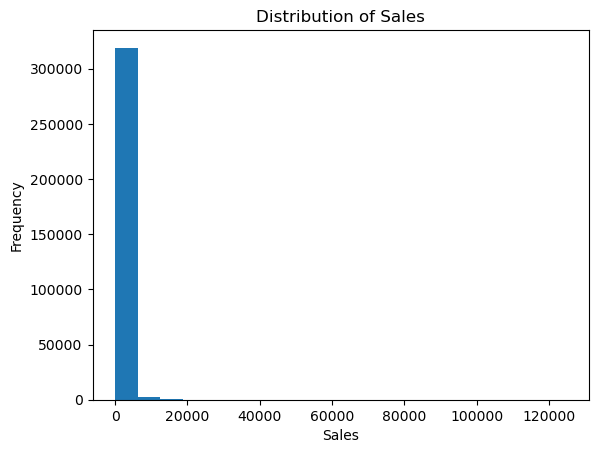

In [35]:
# Histogram
plt.hist(merged_df['sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

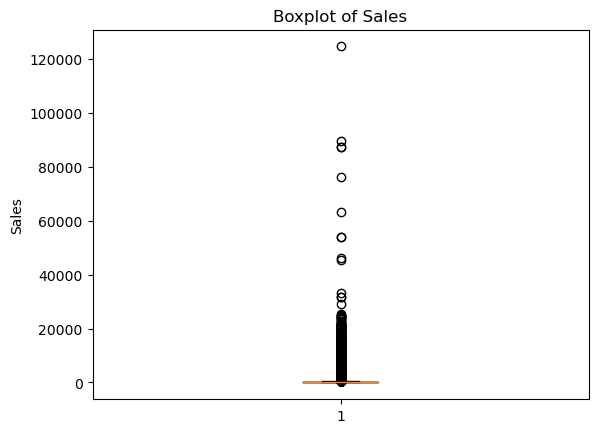

In [36]:
# Boxplot
plt.boxplot(merged_df['sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.show()

#### b. distribution of the 'transactions' variable:

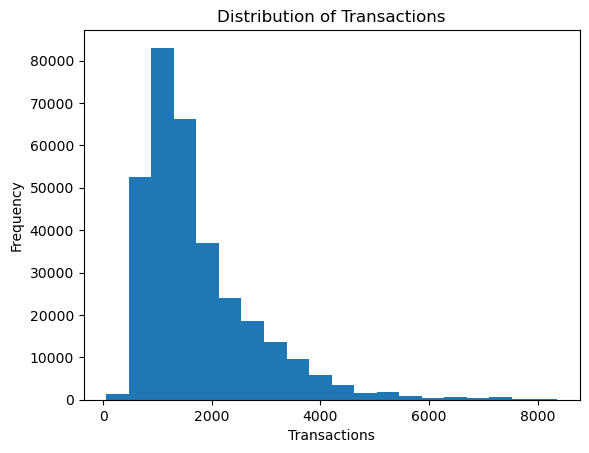

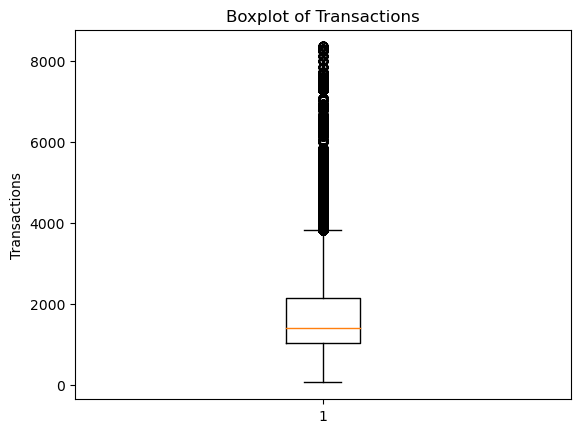

In [37]:
# Histogram
plt.hist(merged_df['transactions'], bins=20)
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.show()

# Boxplot
plt.boxplot(merged_df['transactions'])
plt.ylabel('Transactions')
plt.title('Boxplot of Transactions')
plt.show()

#### c. Distribution of the 'Daily Oil Price' variable:

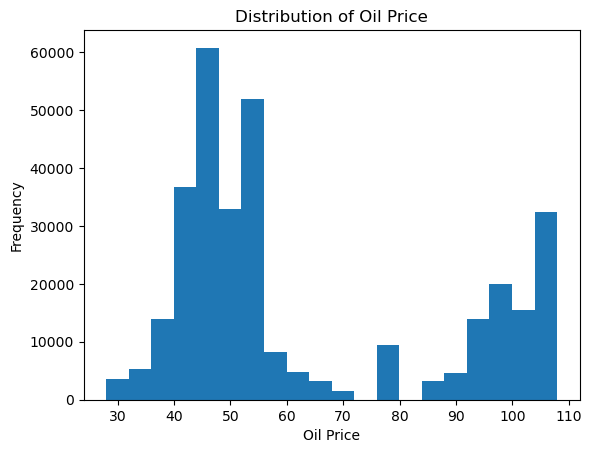

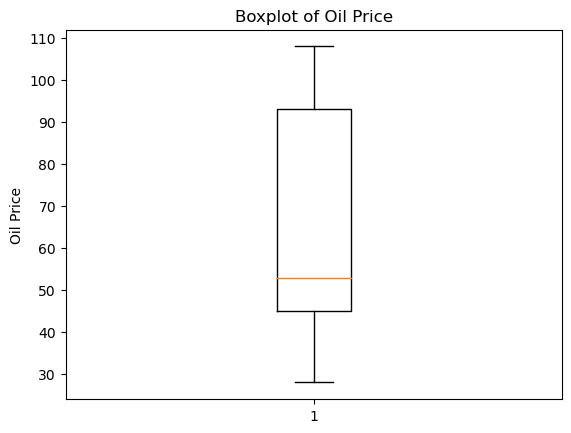

In [38]:
# Histogram
plt.hist(merged_df['dcoilwtico'], bins=20)
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show()

# Boxplot
plt.boxplot(merged_df['dcoilwtico'])
plt.ylabel('Oil Price')
plt.title('Boxplot of Oil Price')
plt.show()

### ii. Bivariate Analysis

In [39]:
# Set the color palette to "viridis"
sns.set_palette("viridis")

#### a. Total Count of Sales by Store Type

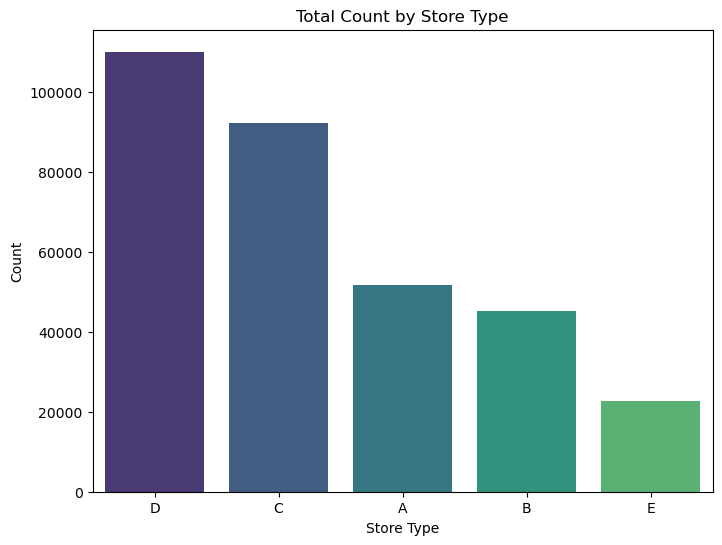

In [40]:
# Calculate the total count and total sales per store type
store_type_counts = merged_df['store_type'].value_counts()
store_type_sales = merged_df.groupby('store_type')['sales'].sum()

# Create a bar plot with "viridis" color palette for total count
plt.figure(figsize=(8, 6))
sns.barplot(x=store_type_counts.index, y=store_type_counts.values)
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Total Count by Store Type')
plt.show()

The analysis of the total count of sales by store type provides insights into the sales performance and customer demand across different store types. Store Type D stands out with the highest count of sales, suggesting a strong customer base and popularity of products offered. Store Type C follows with a relatively lower count of sales, indicating a significant customer base as well. On the other hand, Store Types A, B, and E have lower counts, suggesting potential areas for improvement or the need to address competition.

#### b. Total Amount in Sales by Store Type

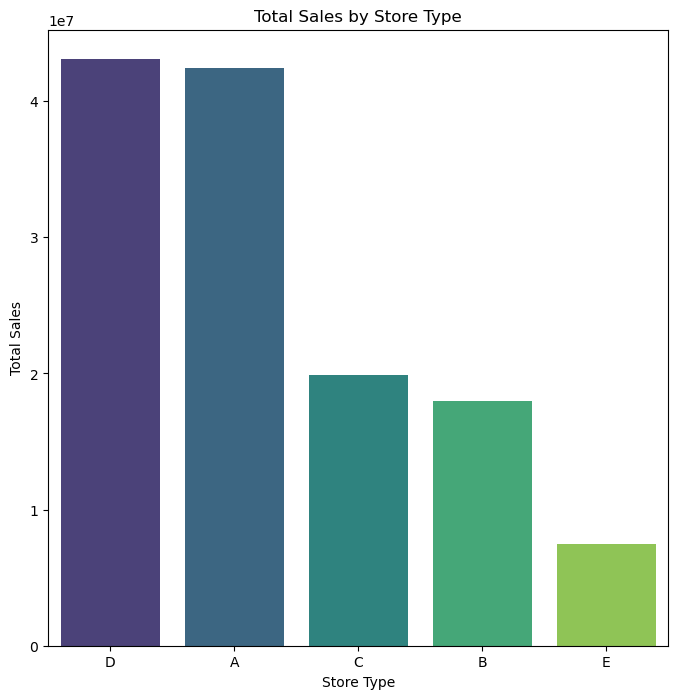

In [41]:
# Order the store types by total sales
store_type_sales = store_type_sales.sort_values(ascending=False)

# Create a bar plot with "viridis" color palette for total sales
plt.figure(figsize=(8, 8))
sns.barplot(x=store_type_sales.index, y=store_type_sales.values, order=store_type_sales.index, palette="viridis")
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Type')
plt.show()

The total sales amount varies across different store types. Store Type D has the highest total sales, indicating its significant contribution to the overall sales. Store Type A follows closely behind, demonstrating its substantial sales performance. Store Type C ranks third in terms of total sales, while Store Type B and Store Type E have lower sales amounts. Understanding the variations in sales by store type helps identify the key drivers of revenue and highlights the importance of certain store types in driving overall sales.

#### c. Trend of sales over time for a specific store (store 1).

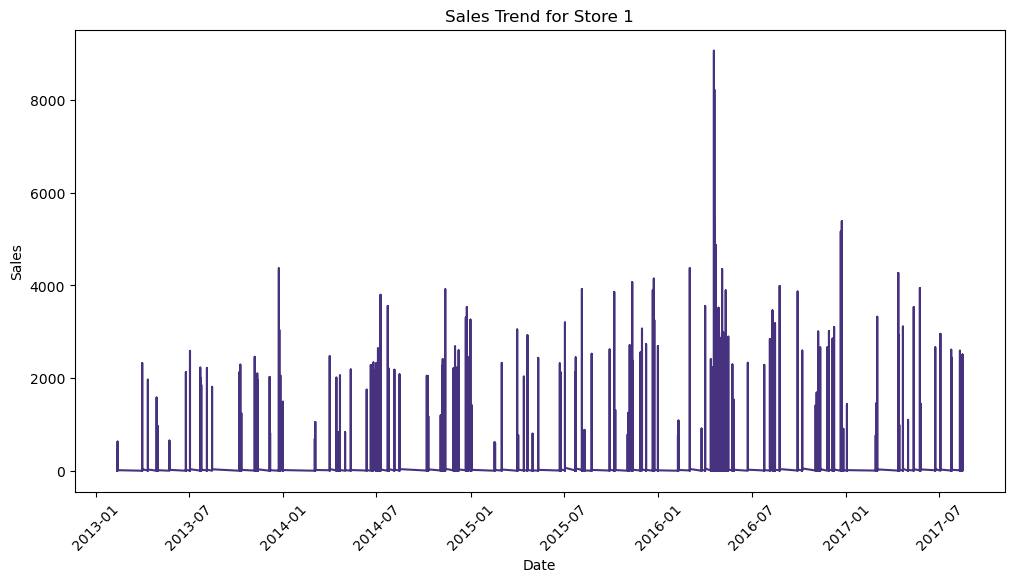

In [42]:
# Trend of sales over time for a specific store (store 1)
store_sales = merged_df[merged_df['store_nbr'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(store_sales['date'], store_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend for Store 1')
plt.xticks(rotation=45)
plt.show()

The plot shows the sales trend for Store 1. From the graph, we can observe that the sales exhibit some variations and fluctuations over time. There are periods of both high and low sales, indicating potential seasonality or other factors affecting sales patterns.

#### d. Average Sales by City

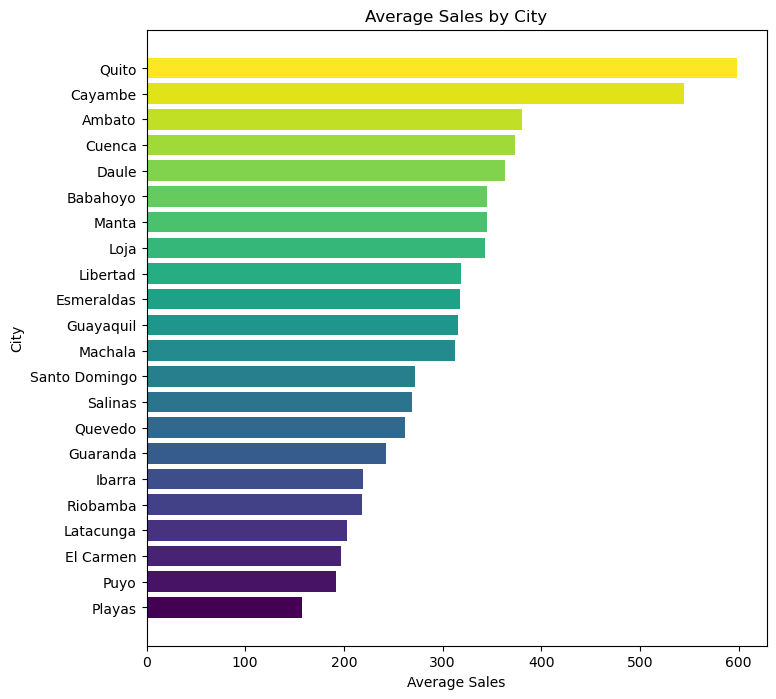

In [43]:
# Group by city and calculate the average sales
average_sales_by_city = merged_df.groupby('city')['sales'].mean()

# Sort the data by average sales in ascending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Define colors for the bar plot using 'viridis' color palette
colors = cm.viridis(np.linspace(0, 1, len(average_sales_by_city)))

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

Quito has the highest number of stores, significantly surpassing other cities. Cayambe is the second most populated city in terms of stores followed by Ambato, Daule and Loja. Some cities have a moderate number of stores while others have a lower number of stores. Puyo has the lowest number of sales.

#### e. Average Sales by State

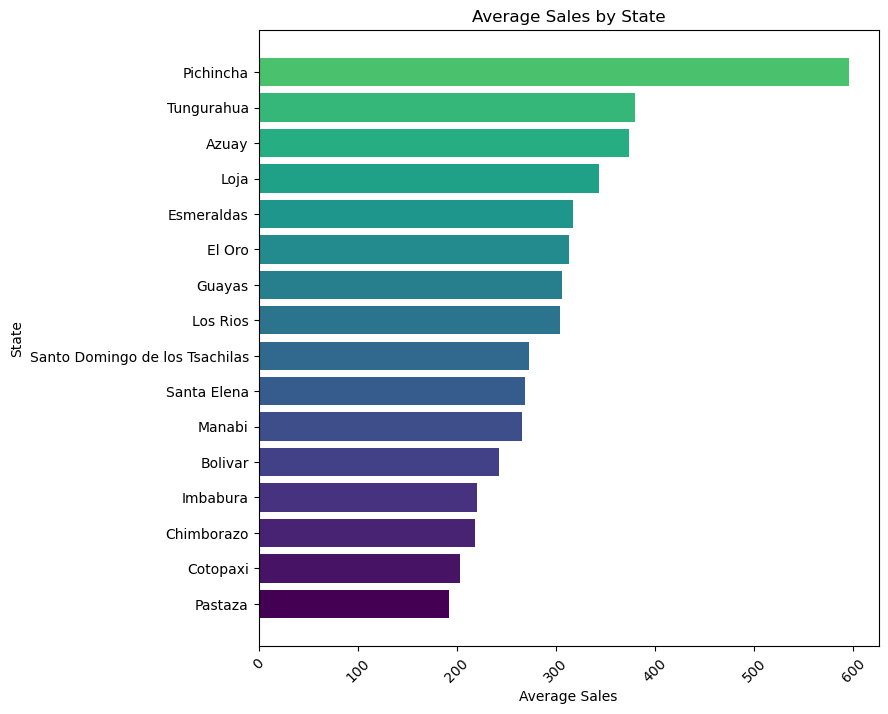

In [44]:
# Group by state and calculate the average sales
average_sales_by_state = merged_df.groupby('state')['sales'].mean()

# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

Pichincha has the highest number of stores, primarily due to the presence of Quito, the capital city. Guayas is the second most populous state in terms of stores, with Guayaquil being a major city. Santo Domingo de los Tsachilas, Azuay, Manabi, Cotopaxi, Tungurahua, Los Rios, El Oro, Chimborazo, Imbabura, Bolivar, Pastaza, Santa Elena, and Loja have a moderate number of stores.

### iii. Multivariate Analysis

#### a. Relationship between sales and transactions.

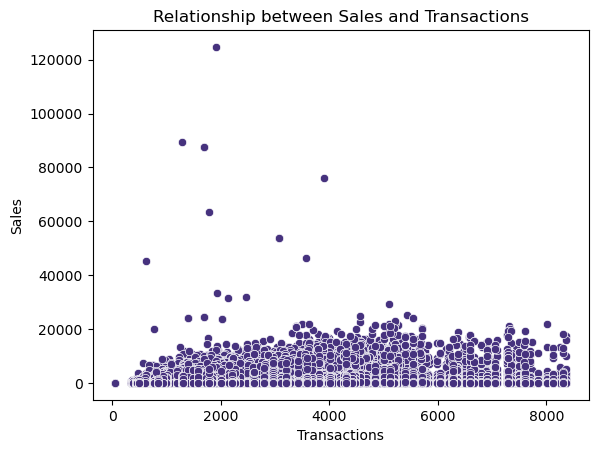

In [45]:
sns.scatterplot(x='transactions', y='sales', data=merged_df)
plt.xlabel('Transactions')
plt.ylabel('Sales')
plt.title('Relationship between Sales and Transactions')
plt.show()

#### b. Correlation matrix of numerical variables

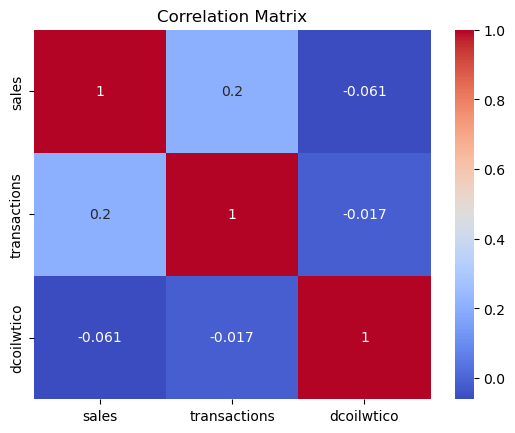

In [46]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr_matrix = merged_df[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### c. Scatter Plot Marrix of numerical Variables

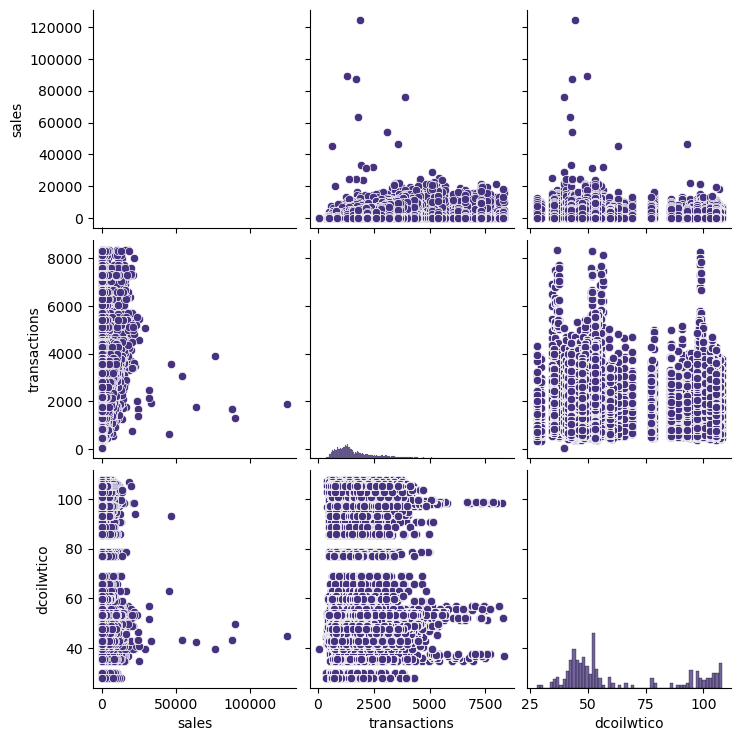

In [47]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Plot scatter plot matrix
sns.pairplot(merged_df[numerical_vars])
plt.show()

## Stationarity Test

In [48]:
# Perform ADF test on the time series data
result = adfuller(merged_df)

# Extract the p-value from the test result
p_value = result[1]
p_value

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
# Check the significance level of the p-value
if p_value < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

## Answering Questions and Hypothesis

### Questions

#### 1. Is the train dataset complete (has all the required dates)?

In [ ]:
# Check if the train dataset has all the required dates
date_range = pd.date_range(train_df['date'].min(), train_df['date'].max(), freq='D')
missing_dates = date_range[~date_range.isin(pd.to_datetime(train_df['date']))]
is_dataset_complete = len(missing_dates) == 0

print("Is the train dataset complete? ", is_dataset_complete)
print("Missing dates: ", missing_dates)

#### 2. Which dates have the lowest and highest sales for each year?

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year

lowest_sales_dates = train_df.groupby('year')['date'].min()
lowest_sales_dates
highest_sales_dates = train_df.groupby('year')['date'].max()

print("Dates with the lowest sales for each year:\n", lowest_sales_dates)
print('==='*15)
print("Dates with the highest sales for each year:\n", highest_sales_dates)

#### 3. Analyze the impact of the earthquake on sales

In [ ]:
# Assign the variable earthquake_date to the date the earthquake took place (April 16, 2016)
earthquake_date = pd.to_datetime('2016-04-16')

# Filter the sales data before and after the earthquake
sales_before_earthquake = train_df[train_df['date'] < earthquake_date]['sales']
sales_after_earthquake = train_df[train_df['date'] > earthquake_date]['sales']

# Set the colormap to viridis
colormap = cm.get_cmap('viridis')

# Plot the sales before and after the earthquake
plt.plot(sales_before_earthquake, color=colormap(0.2), label='Sales Before Earthquake')
plt.plot(sales_after_earthquake, color=colormap(0.8), label='Sales After Earthquake')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

There was a surge in sales after the eathquake.

#### 4. Determine if certain groups of stores sell more products

In [ ]:
# Group by cluster and calculate the average sales
average_sales_by_cluster = merged_df.groupby('cluster')['sales'].mean()

# Group by city and calculate the average sales
average_sales_by_city = merged_df.groupby('city')['sales'].mean()

# Group by state and calculate the average sales
average_sales_by_state = merged_df.groupby('state')['sales'].mean()

# Group by store type and calculate the average sales
average_sales_by_store_type = merged_df.groupby('store_type')['sales'].mean()

# Set the number of bars in each plot
num_bars = len(average_sales_by_cluster)

# Generate the colors using the viridis palette
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))

In [ ]:
# Sort the data by average sales in descending order
average_sales_by_cluster = average_sales_by_cluster.sort_values(ascending=False)

# Plot the average sales by cluster
plt.figure(figsize=(10, 8))
plt.bar(average_sales_by_cluster.index, average_sales_by_cluster.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.title('Average Sales by Cluster')

# Set the x-tick labels as integers
plt.xticks(range(1, len(average_sales_by_cluster.index) + 1))
plt.show()

The cluster with the highest number of stores is Cluster 5, followed by Clusters 14, 8, 11 and 12. These clusters have a significantly larger number of stores compared to the others.

In [ ]:
# Sort the data by average sales in descending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

Quito has the highest number of stores, significantly surpassing other cities.
Cayambe is the second most populated city in terms of stores followed by Ambato, Daule and Loja. Some cities have a moderate number of stores while others have a lower number of stores. Puyo has the lowest number of sales.

In [ ]:
# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 6))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('State')
plt.ylabel('Average Sales')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

Pichincha has the highest number of stores, primarily due to the presence of Quito, the capital city.
Guayas is the second most populous state in terms of stores, with Guayaquil being a major city.
Santo Domingo de los Tsachilas, Azuay, Manabi, Cotopaxi, Tungurahua, Los Rios, El Oro, Chimborazo, Imbabura, Bolivar, Pastaza, Santa Elena, and Loja have a moderate number of stores.

In [ ]:
# Plot the average sales by store type
plt.bar(average_sales_by_store_type.index, average_sales_by_store_type.values, color=colors)
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store Type')
plt.show()

The store type with the highest average sales is type A followed by Type D. Store Type C has the lowest average sales.

#### 5. Are sales affected by promotions, oil prices and holidays?

In [ ]:
# Calculate correlations between sales and promotions, oil prices, holidays
corr_sales_promotions = merged_df['sales'].corr(train_df['onpromotion'])
corr_sales_oil = train_df['sales'].corr(oil_df['dcoilwtico'])
merged_df = pd.merge(train_df, holidays_events_df, on='date', how='left')
corr_sales_holidays = merged_df['sales'].corr(merged_df['type'] == 'Holiday')

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays}")

Promotions:
- There is a positive correlation of approximately 0.36 between sales and promotions. This suggests that promotions have a moderate positive impact on sales. When promotions are running, there is an increased likelihood of higher sales.

Oil Prices:
- There is a weak negative correlation of approximately -0.05 between sales and oil prices. This indicates that there is a slight negative relationship between sales and oil prices. However, the correlation is close to zero, suggesting that oil prices have minimal impact on sales.

Holidays:
- There is a very weak negative correlation of approximately -0.0002 between sales and holidays. This indicates that there is almost no relationship between sales and holidays. Holidays do not seem to have a significant impact on sales.

These insights suggest that promotions have a relatively stronger influence on sales compared to oil prices and holidays. While promotions positively impact sales, oil prices and holidays show minimal or no relationship with sales.

#### 6. What analysis can we get from the date and its extractable features?

In [ ]:
# Extract additional features from the date
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
merged_df['month'] = merged_df['date'].dt.month
merged_df['season'] = (merged_df['month'] % 12 + 3) // 3  # Assuming a 4-season model
merged_df['is_holiday'] = merged_df['date'].isin(holidays_events_df['date'])

In [ ]:
# Perform analysis using these extracted features
# Plot average sales by day of the week
average_sales_by_dayofweek = merged_df.groupby('day_of_week')['sales'].mean()

plt.bar(average_sales_by_dayofweek.index, average_sales_by_dayofweek.values, color=colors)
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.title('Average Sales by Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

The highest number of sales are recorded during the weekends with Sunday recording the most sales.

In [ ]:
# Plot average sales by month
average_sales_by_month = merged_df.groupby('month')['sales'].mean()

plt.plot(average_sales_by_month.index, average_sales_by_month.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Average Sales by Month')
plt.xticks(range(1, 13))
plt.show()

December has the highest average sales followed by July. 
The lowest average sales are recorded in the month of February.

In [ ]:
# Analyze sales patterns during holidays
holiday_sales = merged_df.groupby('is_holiday')['sales'].mean()

plt.bar(holiday_sales.index.astype(str), holiday_sales.values)
plt.xlabel('Is Holiday')
plt.ylabel('Average Sales')
plt.title('Sales Patterns During Holidays')
plt.show()


Based on the plot showing sales patterns during holidays, it appears that the average sales during holidays (Is Holiday = True) are higher compared to non-holiday periods (Is Holiday = False). This suggests that holidays have a positive impact on sales.